### Number of autual image in folder

In [5]:
import os

root_dir = 'noaug'

image_extensions = ('.jpg', '.jpeg', '.png')

total_images = 0
subfolder_counts = {}

for subfolder in ['train', 'val', 'test']:
    subfolder_path = os.path.join(root_dir, subfolder)
    if os.path.exists(subfolder_path):
        image_count = len([f for f in os.listdir(subfolder_path) 
                          if os.path.isfile(os.path.join(subfolder_path, f)) 
                          and f.lower().endswith(image_extensions)])
        subfolder_counts[subfolder] = image_count
        total_images += image_count
    else:
        subfolder_counts[subfolder] = 0

# Print results
print("\nImage counts by subfolder:")
for subfolder, count in subfolder_counts.items():
    print(f"  {subfolder}/: {count} images")

print(f"Total images in '{root_dir}': {total_images}")


Image counts by subfolder:
  train/: 11458 images
  val/: 2100 images
  test/: 2100 images
Total images in 'noaug': 15658


### Number of image in json file

In [7]:
import json
import os
from collections import defaultdict

base_path = 'noaug/annotations/'
splits = ['train', 'val', 'test']
categories = ['ba', 'eo', 'erb', 'ig', 'lym', 'mono', 'neut', 'platelet']

def analyze_split(split):
    json_path = os.path.join(base_path, f'{split}.json')
    if not os.path.exists(json_path):
        print(f"Error: {json_path} not found.")
        return 0, defaultdict(set)
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    total_images = len(data['images'])
    
    category_map = {cat['id']: cat['name'] for cat in data['categories']}

    images_per_category = defaultdict(set)
    for ann in data['annotations']:
        image_id = ann['image_id']
        category_id = ann['category_id']
        category_name = category_map.get(category_id, 'unknown')
        images_per_category[category_name].add(image_id)
    
    return total_images, images_per_category

total_dataset_images = 0
for split in splits:
    total_images, images_per_category = analyze_split(split)
    total_dataset_images += total_images
    
    print(f"\nSplit: {split}")
    print(f"Total Images: {total_images}")
    print("Images per Category:")
    for cat in categories:
        num_images = len(images_per_category[cat])
        print(f"  {cat}: {num_images} images")
    
print(f"\nTotal Images in Dataset: {total_dataset_images}")


Split: train
Total Images: 11458
Images per Category:
  ba: 494 images
  eo: 2209 images
  erb: 905 images
  ig: 2122 images
  lym: 604 images
  mono: 786 images
  neut: 2702 images
  platelet: 3542 images

Split: val
Total Images: 2100
Images per Category:
  ba: 300 images
  eo: 300 images
  erb: 300 images
  ig: 300 images
  lym: 306 images
  mono: 305 images
  neut: 321 images
  platelet: 1796 images

Split: test
Total Images: 2100
Images per Category:
  ba: 300 images
  eo: 301 images
  erb: 302 images
  ig: 303 images
  lym: 307 images
  mono: 304 images
  neut: 326 images
  platelet: 1781 images

Total Images in Dataset: 15658


In [9]:
from PIL import Image

image = Image.open("noaug/train/BA_214889.jpg") 

image.show()


Opening in existing browser session.


In [8]:
import os
import collections

def count_images_per_class(synthetic_dir, num_classes=8):
    # Map class IDs to category names
    class_names = {
        1: "ba",
        2: "eo",
        3: "erb",
        4: "ig",
        5: "lym",
        6: "mono",
        7: "neut",
        8: "platelet"
    }
    
    # Initialize counter for class IDs
    class_counts = collections.Counter()
    
    # Ensure directory exists
    if not os.path.exists(synthetic_dir):
        print(f"Directory {synthetic_dir} does not exist.")
        return {class_names[i]: 0 for i in range(1, num_classes + 1)}
    
    # List all .jpg files
    for filename in os.listdir(synthetic_dir):
        if filename.endswith('.jpg'):
            # Parse class ID from filename (e.g., class_1_0001.jpg -> class_id=1)
            try:
                class_id = int(filename.split('_')[1])
                if 1 <= class_id <= num_classes:
                    class_counts[class_id] += 1
            except (IndexError, ValueError):
                print(f"Skipping invalid filename: {filename}")
    
    # Create result dictionary with class names and counts
    result = {class_names[i]: class_counts.get(i, 0) for i in range(1, num_classes + 1)}
    
    # Print counts
    print("Synthetic images per class:")
    for class_name, count in result.items():
        print(f"{class_name}: {count}")
    
    return result

def main():
    synthetic_dir = 'noaug/synthetic_images'  # Replace with actual path
    counts = count_images_per_class(synthetic_dir, num_classes=8)

if __name__ == '__main__':
    main()

Synthetic images per class:
ba: 3055
eo: 1355
erb: 2642
ig: 1450
lym: 2965
mono: 2780
neut: 933
platelet: 1698


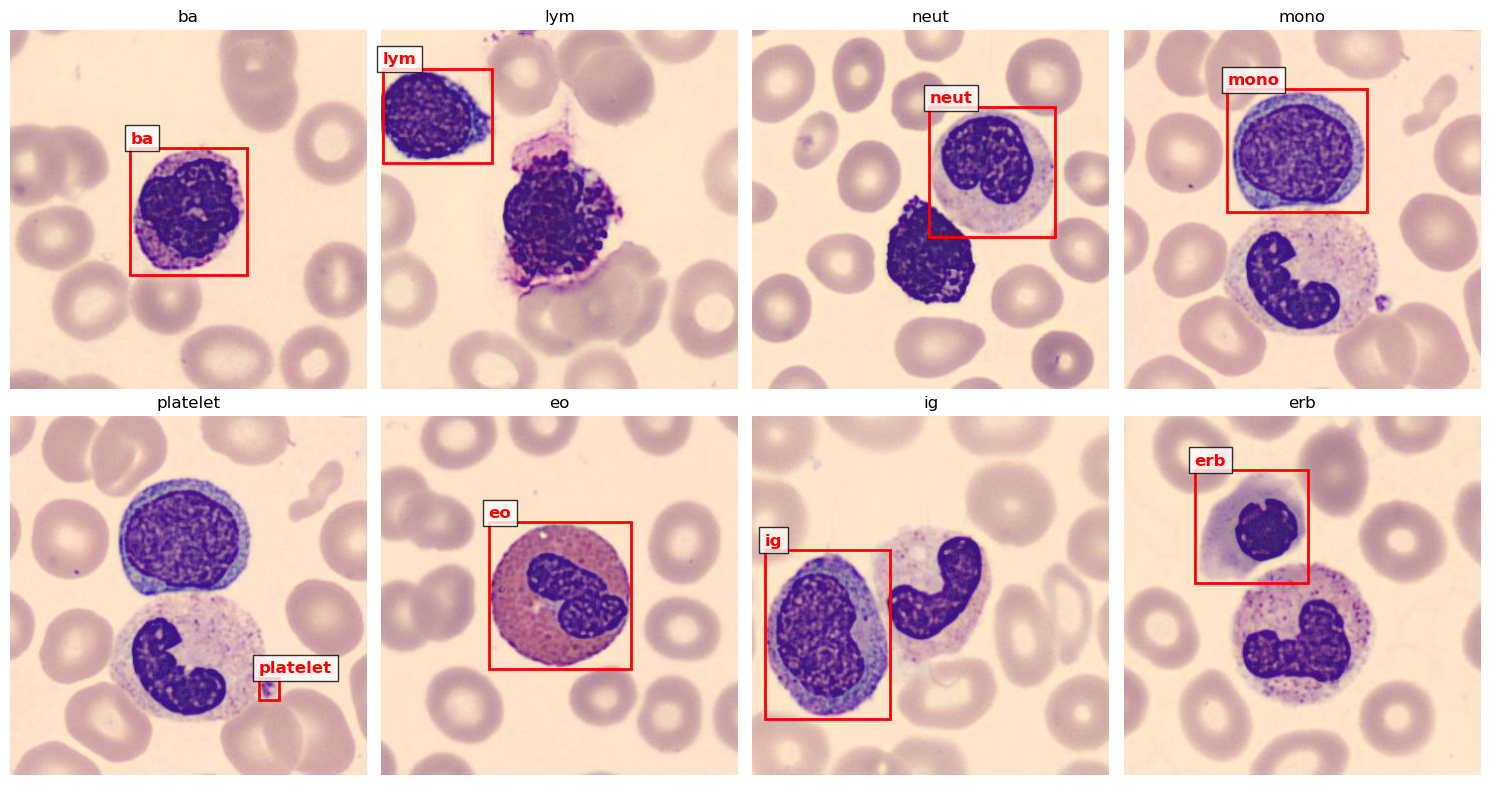

In [9]:
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Paths
data_dir = 'noaug'
ann_file = os.path.join(data_dir, 'annotations', 'train.json')
image_dir = os.path.join(data_dir, 'train')

# Load JSON annotations
with open(ann_file, 'r') as f:
    data = json.load(f)

# Extract images, annotations, and categories
images = data['images']
annotations = data['annotations']
categories = data['categories']

# Create a mapping of category ID to name
category_map = {cat['id']: cat['name'] for cat in categories}

# Find one image per category
category_to_image = {}
for ann in annotations:
    cat_id = ann['category_id']
    if cat_id not in category_to_image:
        # Find the image corresponding to this annotation
        image_id = ann['image_id']
        image_info = next((img for img in images if img['id'] == image_id), None)
        if image_info:
            category_to_image[cat_id] = {
                'image_info': image_info,
                'bbox': ann['bbox'],
                'category_name': category_map[cat_id]
            }
    # Stop once we have one image per category
    if len(category_to_image) == len(categories):
        break

# Plot one image per category
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 2x4 grid for 8 categories
axes = axes.flatten()  # Flatten for easier iteration

for idx, (cat_id, info) in enumerate(category_to_image.items()):
    # Load image
    image_path = os.path.join(image_dir, info['image_info']['file_name'])
    if not os.path.exists(image_path):
        print(f"Image {image_path} not found, skipping...")
        continue
    image = Image.open(image_path)

    # Plot image
    ax = axes[idx]
    ax.imshow(image)

    # Add bounding box
    bbox = info['bbox']
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3],
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)

    # Add category label
    ax.text(
        bbox[0], bbox[1] - 5, info['category_name'],
        color='r', fontsize=12, weight='bold',
        bbox=dict(facecolor='white', alpha=0.8)
    )

    # Set title and remove axes
    ax.set_title(info['category_name'])
    ax.axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()